<a href="https://colab.research.google.com/github/JosiahLC/games-sales-rating/blob/main/sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
!pip install category_encoders==2.*
!pip install shap
!pip install pdpbox
!pip install xgboost
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap
from xgboost import XGBRegressor
from matplotlib import pyplot as plt

In [3]:
pd.options.display.max_rows = 200

In [4]:

df = pd.read_csv(r'vgsales.csv',parse_dates=['Year_of_Release'],index_col='Year_of_Release')
df = df.sort_index(ascending=False)
df.head(30)

,Name,Platform,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
Year_of_Release,,,,,,,,,,,,,,,
2020-01-01,Imagine: Makeup Artist,DS,Simulation,Ubisoft,0.27,0.00,0.00,0.02,0.29,NaN,NaN,tbd,NaN,Ubisoft,E
2017-01-01,Phantasy Star Online 2 Episode 4: Deluxe Package,PS4,Role-Playing,Sega,0.00,0.00,0.04,0.00,0.04,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,Brothers Conflict: Precious Baby,PSV,Action,Idea Factory,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,Phantasy Star Online 2 Episode 4: Deluxe Package,PSV,Role-Playing,Sega,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01,Winning Post 8 2016,PSV,Simulation,Tecmo Koei,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01,The Technomancer,PC,Role-Playing,Focus Home Interactive,0.00,0.01,0.00,0.00,0.01,56.0,34.0,6.8,149.0,"Spidersoft, Spiders",M
2016-01-01,Battlefield 1,PC,Shooter,Electronic Arts,0.11,0.24,0.00,0.03,0.38,88.0,54.0,7.6,1137.0,EA DICE,M
2016-01-01,NHL 17,XOne,Sports,Electronic Arts,0.20,0.01,0.00,0.03,0.24,77.0,23.0,4,38.0,"EA Canada, EA Vancouver",E10+
2016-01-01,Madden NFL 17,X360,Sports,Electronic Arts,0.14,0.02,0.00,0.02,0.17,NaN,NaN,0.7,6.0,EA Sports,E


In [5]:
df['Developer'].value_counts()

Ubisoft                            204
EA Sports                          172
EA Canada                          167
Konami                             162
Capcom                             139
                                  ... 
Camouflaj, LLC                       1
Headup Games                         1
EA Redwood Shores, EA Salt Lake      1
LDW                                  1
Astroll                              1
Name: Developer, Length: 1696, dtype: int64

In [6]:
dev = df['Developer'].value_counts()[df['Developer'].value_counts()>100].index.tolist()
pub = df['Publisher'].value_counts()[df['Publisher'].value_counts()>100].index.tolist()
plat = df['Platform'].value_counts()[df['Platform'].value_counts()>90].index.tolist()

In [7]:
df['dev']=np.where(df['Developer'].isin(dev),df['Developer'],'few developments')
df['pub']=np.where(df['Publisher'].isin(pub),df['Publisher'],'few publishments')
df['plat']=np.where(df['Platform'].isin(plat),df['Platform'],'small platform')
df.drop(columns=['Publisher','Developer','Platform'],inplace=True)

In [8]:
import seaborn as sns

In [9]:
target = 'Global_Sales'
Xn = df.drop(columns=['NA_Sales', 'EU_Sales','JP_Sales','Other_Sales', target,'Name'])
y=df[target]
#Regression problem
#i will consider meanabserror rootmean and r^2
#date cutoff split
#i have removed NA,EU,JP,and other sales, and may use those as targets to futher evaluate the data
#the name column has been removed because of HCC

In [10]:
Xn['Rating'].fillna('NR/na',inplace=True)
Xn['Genre'].fillna('NR/na',inplace=True)


In [11]:
Xn['User_Score'] = pd.to_numeric(Xn['User_Score'],errors='coerce')


In [12]:
Xn.fillna(0,inplace=True)

In [13]:
Xn.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16719 entries, 2020-01-01 to NaT
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Genre         16719 non-null  object 
 1   Critic_Score  16719 non-null  float64
 2   Critic_Count  16719 non-null  float64
 3   User_Score    16719 non-null  float64
 4   User_Count    16719 non-null  float64
 5   Rating        16719 non-null  object 
 6   dev           16719 non-null  object 
 7   pub           16719 non-null  object 
 8   plat          16719 non-null  object 
dtypes: float64(4), object(5)
memory usage: 1.3+ MB


In [14]:
ohe = OneHotEncoder(use_cat_names=True)
ohe.fit(Xn)
X = ohe.transform(Xn)

In [15]:
y.shape

(16719,)

In [16]:
X.shape

(16719, 88)

In [17]:
corla = X.corrwith(y,)

In [18]:
corla.sort_values()

pub_few publishments                         -0.119007
Genre_Adventure                              -0.065949
Rating_NR/na                                 -0.059854
plat_PSP                                     -0.052329
dev_few developments                         -0.044441
plat_PSV                                     -0.042956
plat_PC                                      -0.042789
pub_Namco Bandai Games                       -0.041350
plat_DS                                      -0.039356
Genre_Strategy                               -0.037072
pub_Tecmo Koei                               -0.035764
plat_XB                                      -0.032378
pub_Idea Factory                             -0.029139
pub_Konami Digital Entertainment             -0.028858
pub_D3Publisher                              -0.027568
pub_Unknown                                  -0.025823
plat_SAT                                     -0.022419
plat_GBA                                     -0.021459
pub_Zoo Di

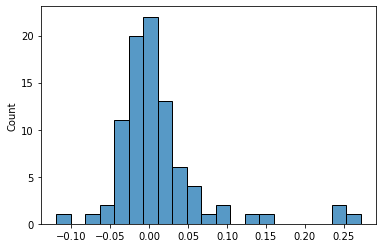

In [19]:
sns.histplot(corla)


In [20]:
X_train,y_train = X[:'2010-01-01'],y[:'2010-01-01']
X_val,y_val = X['2010-01-01':],y['2010-01-01':]

In [21]:
y_pred = [y_train.mean()]*len(y_train)

baseline_mae = mean_absolute_error(y_train, y_pred)
print('Baseline MAE:', baseline_mae)

Baseline MAE: 0.6006414194697872


In [22]:
X_train.columns

Index(['Genre_Simulation', 'Genre_Role-Playing', 'Genre_Action',
       'Genre_Shooter', 'Genre_Sports', 'Genre_Misc', 'Genre_Adventure',
       'Genre_Strategy', 'Genre_Racing', 'Genre_Fighting', 'Genre_Platform',
       'Genre_Puzzle', 'Genre_NR/na', 'Critic_Score', 'Critic_Count',
       'User_Score', 'User_Count', 'Rating_E', 'Rating_NR/na', 'Rating_M',
       'Rating_E10+', 'Rating_T', 'Rating_EC', 'Rating_RP', 'Rating_AO',
       'Rating_K-A', 'dev_Ubisoft', 'dev_few developments', 'dev_EA Sports',
       'dev_Konami', 'dev_Ubisoft Montreal', 'dev_Capcom', 'dev_EA Tiburon',
       'dev_EA Canada', 'dev_Electronic Arts', 'pub_Ubisoft', 'pub_Sega',
       'pub_Idea Factory', 'pub_Tecmo Koei', 'pub_few publishments',
       'pub_Electronic Arts', 'pub_Square Enix', 'pub_Capcom',
       'pub_Konami Digital Entertainment', 'pub_Activision', 'pub_505 Games',
       'pub_Unknown', 'pub_Sony Computer Entertainment',
       'pub_Nippon Ichi Software', 'pub_Namco Bandai Games', 'pub_Ninten

In [23]:
model_r = Ridge()
model_rf = RandomForestRegressor() 
model_xgbr = XGBRegressor()
model_r.fit(X_train,y_train)
model_rf.fit(X_train,y_train)
model_xgbr.fit(X_train,y_train)

[22:38:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [24]:
def check_metrics(model):
  print(model)
  print('Training MAE:', mean_absolute_error(y_train,model.predict(X_train)))
  print('Validation MAE:', mean_absolute_error(y_val,model.predict(X_val)))
  print('R2 score:', model.score(X_val,y_val))

model = [model_r,model_rf,model_xgbr]
for m in model:
  check_metrics(m)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
Training MAE: 0.5223320389390967
Validation MAE: 0.5208561263269881
R2 score: 0.19141414184009142
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
Training MAE: 0.2329000068833265
Validation MAE: 0.236408148842476
R2 score: 0.7416817621486498
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_

In [25]:
model_rfp = make_pipeline(OneHotEncoder(use_cat_names=True),
                          RandomForestRegressor())
model_rfp.fit(X_train,y_train)


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=[], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=True, verbose=0)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=Fal

In [26]:
X.columns

Index(['Genre_Simulation', 'Genre_Role-Playing', 'Genre_Action',
       'Genre_Shooter', 'Genre_Sports', 'Genre_Misc', 'Genre_Adventure',
       'Genre_Strategy', 'Genre_Racing', 'Genre_Fighting', 'Genre_Platform',
       'Genre_Puzzle', 'Genre_NR/na', 'Critic_Score', 'Critic_Count',
       'User_Score', 'User_Count', 'Rating_E', 'Rating_NR/na', 'Rating_M',
       'Rating_E10+', 'Rating_T', 'Rating_EC', 'Rating_RP', 'Rating_AO',
       'Rating_K-A', 'dev_Ubisoft', 'dev_few developments', 'dev_EA Sports',
       'dev_Konami', 'dev_Ubisoft Montreal', 'dev_Capcom', 'dev_EA Tiburon',
       'dev_EA Canada', 'dev_Electronic Arts', 'pub_Ubisoft', 'pub_Sega',
       'pub_Idea Factory', 'pub_Tecmo Koei', 'pub_few publishments',
       'pub_Electronic Arts', 'pub_Square Enix', 'pub_Capcom',
       'pub_Konami Digital Entertainment', 'pub_Activision', 'pub_505 Games',
       'pub_Unknown', 'pub_Sony Computer Entertainment',
       'pub_Nippon Ichi Software', 'pub_Namco Bandai Games', 'pub_Ninten

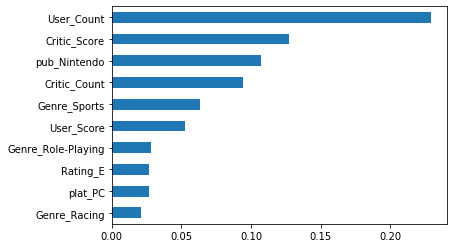

In [31]:
importances =  model_rfp.named_steps['randomforestregressor'].feature_importances_
feature_names = X_train.columns
feat_imp =pd.Series(data=importances,index=feature_names).sort_values(key=abs)
feat_imp.tail(10).plot(kind='barh')

In [28]:
feat_imp

Rating_RP                                     0.000000
plat_WiiU                                     0.000000
plat_3DS                                      0.000000
plat_XOne                                     0.000000
plat_PSV                                      0.000000
plat_PS4                                      0.000000
Rating_EC                                     0.000002
pub_Idea Factory                              0.000005
Rating_AO                                     0.000011
pub_Nippon Ichi Software                      0.000015
pub_Zoo Digital Publishing                    0.000024
pub_Deep Silver                               0.000025
plat_SAT                                      0.000059
pub_D3Publisher                               0.000061
Genre_NR/na                                   0.000081
pub_Unknown                                   0.000118
pub_Tecmo Koei                                0.000130
dev_Ubisoft Montreal                          0.000137
dev_Electr

In [29]:
print(X_val.shape)
print(X_train.shape)

(12693, 88)
(12424, 88)


(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f53f5004d50>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f53f50e4fd0>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


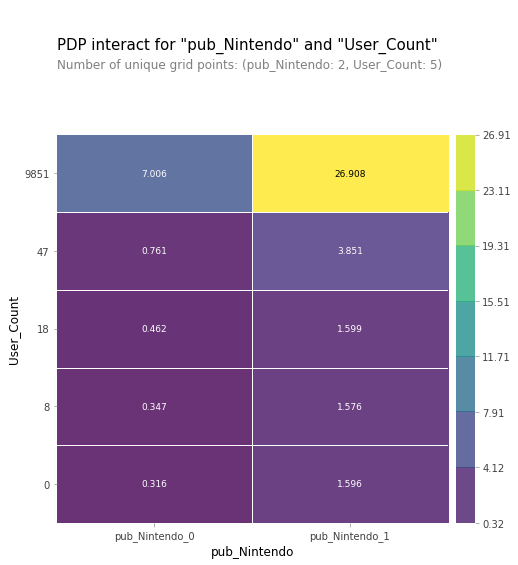

In [30]:
features = ['pub_Nintendo','User_Count']
interact = pdp_interact(model_rf, dataset=X_val,
                        model_features = X_val.columns,
                        features = features)
pdp_interact_plot(interact,plot_type = 'grid',feature_names = features)

In [ ]:
#Summary Plot, Bar: Interaction Values
explainer = shap.Explainer(model_rf, X_val)
shap_values = explainer(X_val,check_additivity=False)
shap.plots.beeswarm(shap_values, max_display=20)

 34%|=======             | 4275/12693 [05:38<11:05]       

In [ ]:
shap.plots.beeswarm(shap_values, max_display=10,log_scale=True,)